In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
class TokenEmbedding(nn.Module):
    def __init__(self, d_model:int, vocab_size:int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(self.vocab_size, self.d_model)

    def forward(self, x):
        return self.embedding(x)

Token Embedding Test

In [29]:
d_model = 64
vocab_size = 1000
embedding_layer = TokenEmbedding(d_model, vocab_size)
toy_input = torch.randint(0,vocab_size, (2,5))
print(toy_input.shape)
toy_output = embedding_layer(toy_input)
print(toy_output.shape)

torch.Size([2, 5])
torch.Size([2, 5, 64])


Output shape: torch.Size([32, 50, 128])


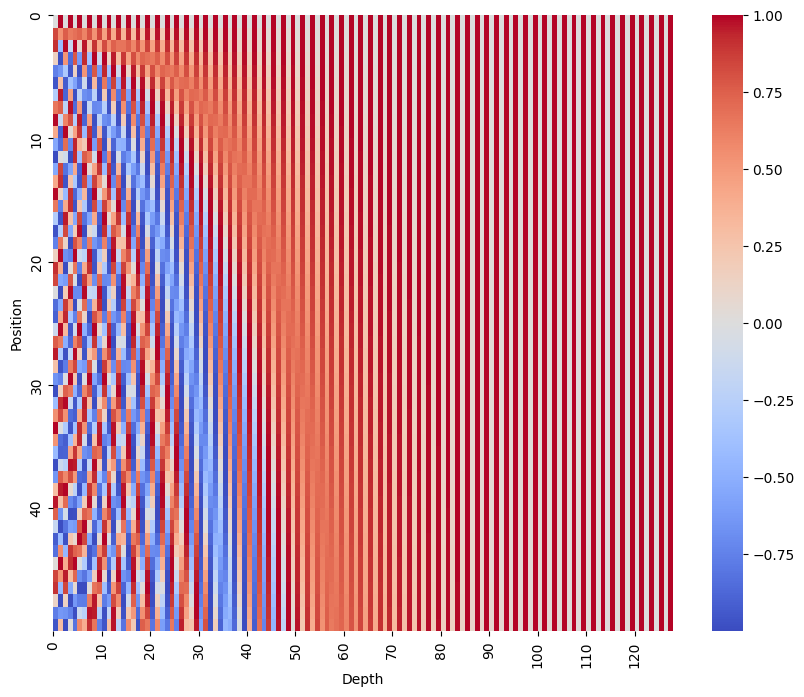

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)  # Add batch dimension

    def visualize_positional_encoding(self, seq_len):
      return self.pe[:, :seq_len, :].squeeze(0)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :].requires_grad_(False)
        return x


d_model = 128
seq_len = 50
batch_size = 32

pos_enc = PositionalEncoding(d_model)

toy_input = torch.randn(batch_size, seq_len, d_model)

output = pos_enc(toy_input)
pos_encoding = pos_enc.visualize_positional_encoding(seq_len)

print("Output shape:", output.shape)


plt.figure(figsize=(10, 8))
sns.heatmap(pos_encoding.numpy(), cmap="coolwarm", center=0, cbar=True)
plt.xticks(ticks=range(0, d_model, 10), labels=range(0, d_model, 10))
plt.yticks(ticks=range(0, seq_len, 10), labels=range(0, seq_len, 10))
plt.xlabel('Depth')
plt.ylabel('Position')
plt.show()

In [5]:
class LayerNormalization(nn.Module):
    def __init__ (self, alpha, beta, eps: float = 10**-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim=True)
        std = x.std(dim = -1, keepdim=True)
        return self.alpha * (x-mean) / (std + self.eps) + self.bias

In [6]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model, hidden, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1)))

In [7]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__ (self, d_model:int, h:int, dropout:float):
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0
        self.dk = d_model // h
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linaer(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout : nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask==0, 1e-9)
        attention_scores = attention_scores.softmax(dim=-1) # (Batch, h, Seq_len, Seq_len)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (Batch, Seq_len, d_model) ==> (Batch, Seq_len, d_model)
        key = self.w_k(k)   # (Batch, Seq_len, d_model) ==> (Batch, Seq_len, d_model)
        value = self.w_v(v) # (Batch, Seq_len, d_model) ==> (Batch, Seq_len, d_model)

        # (Batch, Seq_len, d_model) ==> (Batch, Seq_len, h, d_k) ==> (Batch, h, Seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # (Batch, h, seq_len, d_k) ==> (Batch, Seq_len, h, d_k) ==> (Batch, Seq_len, h*dk)
        x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)


In [8]:
class ScaledDotProduct(nn.Module):
    def __init__ (self, temperature:float, dropout:float):
        super().__init__()
        self.temeprature = temperature
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None, dropout:float = 0.2):
        attn = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(self.temeprature)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        return attn, output

In [9]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.h = h
        self.dk = d_model // h

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.scaled_dot_product = ScaledDotProduct(temperature=math.sqrt(self.dk), dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Linear projections
        # (Batch, Seq_len, d_model) ==> (Batch, Seq_len, h, d_k) ==> (Batch, h, Seq_len, d_k)
        q = self.w_q(q).view(batch_size, q.shape[1], self.h, self.dk).transpose(1, 2)
        k = self.w_k(k).view(batch_size, k.shape[1], self.h, self.dk).transpose(1, 2)
        v = self.w_v(v).view(batch_size, v.shape[1], self.h, self.dk).transpose(1, 2)

        # Apply scaled dot-product attention
        attn, output = self.scaled_dot_product(q, k, v, mask=mask)

        # Concatenate heads and put through final linear layer
        ## (Batch, h, Seq_len, d_k) ==> (Batch, Seq_len, h, d_k) ==> (Batch, Seq_len, h*dk)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.w_o(output)

        return output

MHA Test

In [10]:
d_model = 512
heads = 8
dropout = 0.2
q = torch.randn(2, 100, d_model)
k = torch.randn(2, 100, d_model)
v = torch.randn(2, 100, d_model)
mha = MultiHeadAttentionBlock(d_model, heads, dropout)
output = mha(q,k,v,None)
output.shape

torch.Size([2, 100, 512])

In [11]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
        super().__init__()
        self.attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connection = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connection[0](x, lambda x: self.self_attention_block(x,x,x,src_mask))
        x = self.residual_connection[1](x, self.feed_forward_block)
        return x

In [13]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, heads, hidden, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.hidden = hidden
        self.dropout = nn.Dropout(dropout)
        self.attention = MultiHeadAttentionBlock(d_model, heads, dropout)
        self.layernorm = nn.LayerNorm(self.d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, hidden),
            nn.ReLU(),
            nn.Linear(hidden, d_model),
        )

    def forward(self, x, src_mask):
        attention = self.attention(x,x,x,src_mask)
        x = self.dropout(self.layernorm(x + attention))
        feedforward = self.mlp(x)
        out = self.dropout(self.layernorm(x + feedforward))
        return out

In [15]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x

Encoder Test

In [16]:
d_model = 512
heads = 8
hidden = 2048
num_layers = 6
dropout = 0.1

encoder_blocks = nn.ModuleList([EncoderBlock(d_model, heads, hidden, dropout) for _ in range(num_layers)])

encoder = Encoder(encoder_blocks)

dummy_input = torch.randn(2, 10, d_model)
dummy_mask = None

output = encoder(dummy_input, dummy_mask)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([2, 10, 512])


In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.Module(ResidualConnection(dropout) for _ in range(3))

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x,x,x,tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.self_attention_block(x,encoder_output,encoder_output,src_mask))
        x = self.residual_connection[2](x, self.feed_forward_block)
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

In [19]:
class DecoderBlock(nn.Module):
     def __init__(self, d_model, heads, hidden, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.hidden = hidden
        self.dropout = nn.Dropout(dropout)
        self.attention = MultiHeadAttentionBlock(d_model, heads, dropout)
        self.layernorm = nn.LayerNorm(self.d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, hidden),
            nn.ReLU(),
            nn.Linear(hidden, d_model),
        )

     def forward(self, x, encoder_output, src_mask, tgt_mask):
        attention = self.attention(x,x,x,tgt_mask)
        query = self.dropout(self.layernorm(x + attention))
        cross_out = self.attention(query, encoder_output, encoder_output, src_mask)
        feedforward = self.mlp(cross_out)
        out = self.dropout(self.layernorm(cross_out + feedforward))
        return out

In [20]:
class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return x

Decoder test

In [21]:
d_model = 512
heads = 8
hidden = 2048
num_layers = 6
dropout = 0.1

decoder_blocks = nn.ModuleList([DecoderBlock(d_model, heads, hidden, dropout) for _ in range(num_layers)])

decoder = Decoder(decoder_blocks)

dummy_input = torch.randn(2, 10, d_model)
dummy_encoder_output = torch.randn(2,10, d_model)
dummy_src_mask = None
dummy_tgt_mask = None
output = decoder(dummy_input, dummy_encoder_output, dummy_src_mask, dummy_tgt_mask)
print("Output shape:", output.shape)

Output shape: torch.Size([2, 10, 512])


In [22]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim=-1)

In [23]:
class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: TokenEmbedding, tgt_embed: TokenEmbedding, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding,
                 projection_layer: ProjectionLayer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        return self.projection_layer(x)

In [24]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048):
    src_embed = TokenEmbedding(d_model, src_vocab_size)
    tgt_embed = TokenEmbedding(d_model, tgt_vocab_size)
    src_pos = PositionalEncoding(d_model)
    tgt_pos = PositionalEncoding(d_model)

    encoder_blocks = nn.ModuleList([EncoderBlock(d_model, heads, hidden, dropout) for _ in range(num_layers)])
    encoder = Encoder(encoder_blocks)

    decoder_blocks = nn.ModuleList([DecoderBlock(d_model, heads, hidden, dropout) for _ in range(num_layers)])
    decoder = Decoder(decoder_blocks)

    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    return transformer

In [27]:
def inference_test(transformer, dummy_src, dummy_tgt, src_vocab_size, tgt_vocab_size, d_model, num_layers, heads, dropout):

    dummy_src_mask = None
    dummy_tgt_mask = None

    encoded_src = transformer.encode(dummy_src, dummy_src_mask)

    decoded_tgt = transformer.decode(encoded_src, dummy_src_mask, dummy_tgt[:, :-1], dummy_tgt_mask)

    output = transformer.project(decoded_tgt)

    print("Output shape:", output.shape)

    return output

dummy_src = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]])
dummy_tgt = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]])

src_vocab_size = 20
tgt_vocab_size = 20
d_model = 128
num_layers = 6
heads = 8
dropout = 0.1

transformer = build_transformer(src_vocab_size, tgt_vocab_size, d_model, num_layers, heads, dropout)
output = inference_test(transformer, dummy_src, dummy_tgt, src_vocab_size, tgt_vocab_size, d_model, num_layers, heads, dropout)

Output shape: torch.Size([2, 7, 20])
